# My Attempt to Beat the Streak!

The longest hit streak in Major League Baseball history belongs to Joe Dimaggio in 1941, with Joe recording a hit in 56 straight games. Probabilistically, what he accomplished was quite the feat (the next longest streak in MLB history is a "paltry" 45, accomplished in 1896)!

To understand how unlikely his magical run was, let's dive into the numbers:

For a hitter with an average** of 0.25, given they receive 4 plate appearances a game, the probability of them getting at least one hit in 56 staight games is:

***
    P(at least one hit in a 56 straight games) = P(at least one hit in one game) ** 56 
    P(at least one hit in one game) = 1 - P(no hits in one game)
                                    = 1 - ((3/4) * (3/4) * (3/4) * (3/4))
                                    = 1 - 0.3
    P(at least one hit in one game) ≈ 0.7
    P(at least one hit in a 56 straight games) = 0.7 ** 56 
    ≈ 0.00000000021159, aka basically impossible
  
***

Additionally, this calculation is even too simplistic because it does not take into account non-hit outcomes that would lower this probability even more.

*average** = percent of the time they get a hit = (# of hits) / (# of at-bats)*

Because it is essentially unattainable, the MLB puts out a challenge every year awarding \\$5.6 million to anyone who can beat Joe's streak. The challenge allows you to choose a player every day who you think will get a hit. Pick 57 straight correctly and you can win $5.6 million. Spoiler alert: no one has ever won.

In this project, I create a model that assists me in choosing players who are most likely to record a hit, in hopes of shifting the probability in my favor.

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pybaseball
import requests
import datetime
import warnings
import io
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from pandas.tseries.offsets import DateOffset
from pybaseball import batting_stats_range
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
from IPython.display import display, HTML, Image
display(HTML("<style>.container { width:90% !important; }</style>"))
warnings.filterwarnings("ignore")

### To begin, gather data from 2021 season for training

In [3]:
# to avoid a bug in the python package, I redefine the function that gathers pitching stats from a date range
def get_stats_from_date_range(start, end, stat_type):
    url = "http://www.baseball-reference.com/leagues/daily.cgi?user_team=&bust_cache=&type={}&lastndays=7&dates=fromandto&fromandto={}.{}&level=mlb&franch=&stat=&stat_value=0".format(stat_type, start, end)
    s = requests.get(url).content
    # a workaround to avoid beautiful soup applying the wrong encoding
    s = str(s).encode()
    soup = BeautifulSoup(s, features="lxml")
    table = soup.find_all('table')[0]
    data = []
    headings = [th.get_text() for th in table.find("tr").find_all("th")][1:]
    headings.append("mlbID")
    data.append(headings)
    table_body = table.find('tbody')
    rows = table_body.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        row_anchor = row.find("a")
        mlbid = row_anchor["href"].split("mlb_ID=")[-1] if row_anchor else pd.NA  # ID str or nan
        cols = [ele.text.strip() for ele in cols]
        cols.append(mlbid)
        data.append([ele for ele in cols])
    data = pd.DataFrame(data)
    data = data.rename(columns=data.iloc[0])
    data = data.reindex(data.index.drop(0))
    return data

#### pitcher data

In [2]:
#statcast_2021 = pybaseball.statcast("2021-04-01", "2021-09-30")
statcast_2021 = pd.read_csv("statcast_2021.csv") #saved for convenience

# extract the starting pitcher from each game — with this info, we can factor a 
# pitchers recent perfomance into our model
statcast_2021_first_inning = statcast_2021[statcast_2021["inning"] == 1]
statcast_2021_starting_pitchers = statcast_2021_first_inning.groupby(["pitcher",
                                                                      "game_date",
                                                                      "game_pk"])["player_name"].max()
statcast_2021_starting_pitchers = statcast_2021_starting_pitchers.reset_index()

# starting training data a few weeks in for sufficient sample
starting_pitchers = statcast_2021_starting_pitchers[statcast_2021_starting_pitchers["game_date"] >= "2021-05-01"]
starting_pitchers["game_date"] = pd.to_datetime(starting_pitchers["game_date"]).dt.date
starting_pitchers = starting_pitchers.sort_values("game_date")
starting_pitchers["Name"] = [" ".join(name.split(", ")[::-1]) for name in starting_pitchers["player_name"]]
starting_pitchers

,pitcher,game_date,game_pk,player_name,Name
985,543475,2021-05-01,634271,"Lyles, Jordan",Jordan Lyles
1220,571578,2021-05-01,634304,"Corbin, Patrick",Patrick Corbin
579,502239,2021-05-01,634284,"Cahill, Trevor",Trevor Cahill
4169,664157,2021-05-01,634312,"Bergen, Travis",Travis Bergen
672,518633,2021-05-01,634329,"Duffy, Danny",Danny Duffy
...,...,...,...,...,...
4564,669373,2021-09-30,632285,"Skubal, Tarik",Tarik Skubal
1015,543521,2021-09-30,632292,"McHugh, Collin",Collin McHugh
3426,649144,2021-09-30,632294,"Wells, Alexander",Alexander Wells
3719,657006,2021-09-30,632286,"Steele, Justin",Justin Steele


In [5]:
# starting on May 1st, gather data from previous 45 days for every starting pitcher on date
key_cols = ['pitcher', 'game_date', 'game_pk', 'player_name', 'Name']

starting_pitcher_stats = pd.DataFrame()
for date, group in starting_pitchers.groupby("game_date"):
    print(date)
    recent_pitching_stats = get_stats_from_date_range(str((date - timedelta(days=46))), 
                                                      str((date - timedelta(days=1))),
                                                      "p")
    
    this_days_starting_pitchers = starting_pitchers[starting_pitchers["game_date"] == date][key_cols]
    this_days_starting_pitchers = this_days_starting_pitchers.merge(recent_pitching_stats, on="Name")
    starting_pitcher_stats = pd.concat([starting_pitcher_stats, this_days_starting_pitchers], ignore_index=True) 

starting_pitcher_stats

2021-05-01
2021-05-02
2021-05-03
2021-05-04
2021-05-05
2021-05-06
2021-05-07
2021-05-08
2021-05-09
2021-05-10
2021-05-11
2021-05-12
2021-05-13
2021-05-14
2021-05-15
2021-05-16
2021-05-17
2021-05-18
2021-05-19
2021-05-20
2021-05-21
2021-05-22
2021-05-23
2021-05-24
2021-05-25
2021-05-26
2021-05-27
2021-05-28
2021-05-29
2021-05-30
2021-05-31
2021-06-01
2021-06-02
2021-06-03
2021-06-04
2021-06-05
2021-06-06
2021-06-07
2021-06-08
2021-06-09
2021-06-10
2021-06-11
2021-06-12
2021-06-13
2021-06-14
2021-06-15
2021-06-16
2021-06-17
2021-06-18
2021-06-19
2021-06-20
2021-06-21
2021-06-22
2021-06-23
2021-06-24
2021-06-25
2021-06-26
2021-06-27
2021-06-28
2021-06-29
2021-06-30
2021-07-01
2021-07-02
2021-07-03
2021-07-04
2021-07-05
2021-07-06
2021-07-07
2021-07-08
2021-07-09
2021-07-10
2021-07-11
2021-07-16
2021-07-17
2021-07-18
2021-07-19
2021-07-20
2021-07-21
2021-07-22
2021-07-23
2021-07-24
2021-07-25
2021-07-26
2021-07-27
2021-07-28
2021-07-29
2021-07-30
2021-07-31
2021-08-01
2021-08-02
2021-08-03

,pitcher,game_date,game_pk,player_name,Name,,Age,#days,Lev,Tm,...,StL,StS,GB/FB,LD,PU,WHIP,BAbip,SO9,SO/W,mlbID
0,543475,2021-05-01,634271,"Lyles, Jordan",Jordan Lyles,gl,30,437,Maj-AL,Texas,...,15%,10%,28%,23%,10%,1.542,.324,7.5,3.33,543475
1,571578,2021-05-01,634304,"Corbin, Patrick",Patrick Corbin,gl,31,438,Maj-NL,Washington,...,16%,11%,38%,25%,4%,2.020,.340,7.7,1.40,571578
2,502239,2021-05-01,634284,"Cahill, Trevor",Trevor Cahill,gl,33,439,Maj-NL,Pittsburgh,...,19%,11%,51%,22%,2%,1.421,.351,9.0,3.80,502239
3,664157,2021-05-01,634312,"Bergen, Travis",Travis Bergen,gl,27,435,Maj-AL,Toronto,...,23%,23%,0%,0%,50%,0.000,.000,9.0,,664157
4,518633,2021-05-01,634329,"Duffy, Danny",Danny Duffy,gl,32,438,Maj-AL,Kansas City,...,15%,15%,26%,40%,10%,1.044,.298,10.6,4.50,518633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3590,669373,2021-09-30,632285,"Skubal, Tarik",Tarik Skubal,gl,24,285,Maj-AL,Detroit,...,18%,13%,54%,14%,5%,1.011,.254,10.9,7.20,669373
3591,543521,2021-09-30,632292,"McHugh, Collin",Collin McHugh,gl,34,285,Maj-AL,Tampa Bay,...,17%,11%,47%,24%,5%,1.039,.245,4.7,3.00,543521
3592,649144,2021-09-30,632294,"Wells, Alexander",Alexander Wells,gl,24,286,Maj-AL,Baltimore,...,22%,6%,30%,27%,14%,1.556,.283,4.5,1.80,649144
3593,657006,2021-09-30,632286,"Steele, Justin",Justin Steele,gl,25,286,Maj-NL,Chicago,...,16%,11%,43%,22%,7%,1.642,.299,8.5,1.67,657006


#### hitter data

In [6]:
# set the success criteria for a single game
statcast_2021["hit"] = statcast_2021["events"].isin(["single", "double", "triple", "home_run"]).astype(int)

# aggregate into hitter table with dates and whether they recorded a hit
hitters = statcast_2021.groupby(["game_date", "game_pk", "batter"])["hit"].max().reset_index()
hitters["batter"] = hitters["batter"].astype(str)
hitters = hitters[hitters["game_date"] >= "2021-05-01"]
hitters["game_date"] = pd.to_datetime(hitters["game_date"]).dt.date
hitters

,game_date,game_pk,batter,hit
8084,2021-05-01,634271,502110,1
8085,2021-05-01,634271,518586,1
8086,2021-05-01,634271,543877,1
8087,2021-05-01,634271,571771,0
8088,2021-05-01,634271,592669,1
...,...,...,...,...
50498,2021-09-30,632294,663330,0
50499,2021-09-30,632294,663527,1
50500,2021-09-30,632294,663624,1
50501,2021-09-30,632294,663630,0


In [7]:
# starting on May 1st, gather data from previous 30 days for every hitter on date
hitter_stats = pd.DataFrame()
for date, group in hitters.groupby("game_date"):
    print(date)
    recent_hitting_stats = get_stats_from_date_range(str((date - timedelta(days=31))), 
                                                     str((date - timedelta(days=1))),
                                                     "b")
    this_days_hitters = hitters[hitters["game_date"] == date]
    this_days_hitters = this_days_hitters.merge(recent_hitting_stats, left_on="batter", right_on="mlbID")
    hitter_stats = pd.concat([hitter_stats, this_days_hitters], ignore_index=True)
hitter_stats

2021-05-01
2021-05-02
2021-05-03
2021-05-04
2021-05-05
2021-05-06
2021-05-07
2021-05-08
2021-05-09
2021-05-10
2021-05-11
2021-05-12
2021-05-13
2021-05-14
2021-05-15
2021-05-16
2021-05-17
2021-05-18
2021-05-19
2021-05-20
2021-05-21
2021-05-22
2021-05-23
2021-05-24
2021-05-25
2021-05-26
2021-05-27
2021-05-28
2021-05-29
2021-05-30
2021-05-31
2021-06-01
2021-06-02
2021-06-03
2021-06-04
2021-06-05
2021-06-06
2021-06-07
2021-06-08
2021-06-09
2021-06-10
2021-06-11
2021-06-12
2021-06-13
2021-06-14
2021-06-15
2021-06-16
2021-06-17
2021-06-18
2021-06-19
2021-06-20
2021-06-21
2021-06-22
2021-06-23
2021-06-24
2021-06-25
2021-06-26
2021-06-27
2021-06-28
2021-06-29
2021-06-30
2021-07-01
2021-07-02
2021-07-03
2021-07-04
2021-07-05
2021-07-06
2021-07-07
2021-07-08
2021-07-09
2021-07-10
2021-07-11
2021-07-16
2021-07-17
2021-07-18
2021-07-19
2021-07-20
2021-07-21
2021-07-22
2021-07-23
2021-07-24
2021-07-25
2021-07-26
2021-07-27
2021-07-28
2021-07-29
2021-07-30
2021-07-31
2021-08-01
2021-08-02
2021-08-03

,game_date,game_pk,batter,hit,Name,,Age,#days,Lev,Tm,...,SH,SF,GDP,SB,CS,BA,OBP,SLG,OPS,mlbID
0,2021-05-01,634271,502110,1,J.D. Martinez,gl,33,433,Maj-AL,Boston,...,0,0,6,0,0,.351,.430,.745,1.175,502110
1,2021-05-01,634271,518586,1,Charlie Culberson,gl,32,434,Maj-AL,Texas,...,2,0,1,1,0,.296,.311,.523,.834,518586
2,2021-05-01,634271,543877,1,Christian Vazquez,gl,30,433,Maj-AL,Boston,...,0,0,4,2,0,.238,.281,.357,.638,543877
3,2021-05-01,634271,571771,0,Enrique Hernandez,gl,29,434,Maj-AL,Boston,...,0,1,1,0,0,.230,.271,.400,.671,571771
4,2021-05-01,634271,592669,1,Hunter Renfroe,gl,29,433,Maj-AL,Boston,...,0,2,2,0,1,.167,.235,.250,.485,592669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41664,2021-09-30,632294,657077,0,Alex Verdugo,gl,25,281,Maj-AL,Boston,...,0,2,1,0,0,.321,.352,.432,.784,657077
41665,2021-09-30,632294,663330,0,Jahmai Jones,gl,23,282,Maj-AL,Baltimore,...,0,0,1,1,0,.186,.255,.233,.488,663330
41666,2021-09-30,632294,663624,1,Ryan Mountcastle,gl,24,281,Maj-AL,Baltimore,...,0,0,4,0,0,.219,.305,.467,.772,663624
41667,2021-09-30,632294,663630,0,Ryan McKenna,gl,24,281,Maj-AL,Baltimore,...,0,0,1,0,0,.159,.254,.254,.508,663630


In [8]:
# gather information about player handedness to identify lefty-lefty matchups (this is historically a disadvantage for lefty hitters) 
players = pybaseball.master()
player_id_map = pd.read_csv("player_id_map.csv")
player_id_map = player_id_map[["MLBID", "BREFID"]]
player_id_map = player_id_map.dropna()
player_id_map["MLBID"] = player_id_map["MLBID"].astype(int)
player_handedness = players.merge(player_id_map, left_on="playerID", right_on="BREFID")[["MLBID", "throws", "bats"]]
player_handedness

,MLBID,throws,bats
0,430911,R,R
1,472551,L,L
2,676265,R,R
3,682928,R,L
4,656061,R,R
...,...,...,...
2751,217096,L,L
2752,450314,R,B
2753,676604,R,R
2754,572287,R,R


#### Combine pitching and hitting data

In [9]:
def convert_percentages_to_decimals(col):
    if "%" in str(col.values[0]):
        return col.str.rstrip("%").astype(float) / 100
    else:
        return col
    
# merge hitter and pitcher stats; correct formatting
hitter_stats["team"] = hitter_stats["Tm"] + "-" + hitter_stats["Lev"]
starting_pitcher_stats["team"] = starting_pitcher_stats["Tm"] + "-" + starting_pitcher_stats["Lev"]
complete_stats = hitter_stats.merge(starting_pitcher_stats, on=["game_date", "game_pk"], how="left", suffixes=("_b", "_p"))
complete_stats = complete_stats[complete_stats["team_b"] != complete_stats["team_p"]].reset_index(drop=True)
complete_stats = complete_stats.apply(convert_percentages_to_decimals, axis=0)
complete_stats = complete_stats.apply(lambda x: pd.to_numeric(x, errors="ignore"), axis=0)
complete_stats = complete_stats.dropna(subset=["pitcher"])
complete_stats["pitcher"] = complete_stats["pitcher"].astype(int)

# add hit percentage for both hitter and pitcher
complete_stats["H%_b"] = complete_stats["H_b"] / complete_stats["AB_b"]
complete_stats["H%_p"] = complete_stats["H_p"] / complete_stats["BF"]

# add handedness of pitcher and hitter to dataset
complete_stats = complete_stats.merge(player_handedness[["MLBID", "bats"]],
                                      left_on="mlbID_b", right_on="MLBID", how="left").drop_duplicates().reset_index(drop=True)
complete_stats = complete_stats.merge(player_handedness[["MLBID", "throws"]], 
                                      left_on="mlbID_p", right_on="MLBID", how="left").drop_duplicates().reset_index(drop=True)
complete_stats = complete_stats.dropna(subset=["MLBID_y"]).reset_index(drop=True)
complete_stats["hand_matchup"] = complete_stats["bats"] + complete_stats["throws"]
complete_stats["lefty_lefty"] = (complete_stats["hand_matchup"] == "LL").astype(int)
complete_stats

,game_date,game_pk,batter,hit,Name_b,_b,Age_b,#days_b,Lev_b,Tm_b,...,mlbID_p,team_p,H%_b,H%_p,MLBID_x,bats,MLBID_y,throws,hand_matchup,lefty_lefty
0,2021-05-01,634271,502110,1,J.D. Martinez,gl,33,433,Maj-AL,Boston,...,543475.0,Texas-Maj-AL,0.351064,0.287037,502110.0,R,543475.0,R,RR,0
1,2021-05-01,634271,518586,1,Charlie Culberson,gl,32,434,Maj-AL,Texas,...,593958.0,Boston-Maj-AL,0.295455,0.202247,518586.0,R,593958.0,L,RL,0
2,2021-05-01,634271,543877,1,Christian Vazquez,gl,30,433,Maj-AL,Boston,...,543475.0,Texas-Maj-AL,0.238095,0.287037,543877.0,R,543475.0,R,RR,0
3,2021-05-01,634271,571771,0,Enrique Hernandez,gl,29,434,Maj-AL,Boston,...,543475.0,Texas-Maj-AL,0.230000,0.287037,571771.0,R,543475.0,R,RR,0
4,2021-05-01,634271,592669,1,Hunter Renfroe,gl,29,433,Maj-AL,Boston,...,543475.0,Texas-Maj-AL,0.166667,0.287037,592669.0,R,543475.0,R,RR,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37768,2021-09-30,632294,656775,0,Cedric Mullins,gl,26,281,Maj-AL,Baltimore,...,601713.0,Boston-Maj-AL,0.237113,0.258621,656775.0,L,601713.0,R,LR,0
37769,2021-09-30,632294,663330,0,Jahmai Jones,gl,23,282,Maj-AL,Baltimore,...,601713.0,Boston-Maj-AL,0.186047,0.258621,663330.0,R,601713.0,R,RR,0
37770,2021-09-30,632294,663624,1,Ryan Mountcastle,gl,24,281,Maj-AL,Baltimore,...,601713.0,Boston-Maj-AL,0.219048,0.258621,663624.0,R,601713.0,R,RR,0
37771,2021-09-30,632294,663630,0,Ryan McKenna,gl,24,281,Maj-AL,Baltimore,...,601713.0,Boston-Maj-AL,0.158730,0.258621,663630.0,R,601713.0,R,RR,0


In [10]:
# view summary stats
pd.set_option('display.max_columns', None)
complete_stats.describe()

,game_pk,batter,hit,Age_b,#days_b,G_b,PA,AB_b,R_b,H_b,2B_b,3B_b,HR_b,RBI,BB_b,IBB_b,SO_b,HBP_b,SH,SF_b,GDP_b,SB_b,CS_b,BA,OBP,SLG,OPS,mlbID_b,pitcher,Age_p,#days_p,G_p,GS,W,L,SV,IP,H_p,R_p,ER,BB_p,SO_p,HR_p,HBP_p,ERA,AB_p,2B_p,3B_p,IBB_p,GDP_p,SF_p,SB_p,CS_p,PO,BF,Pit,Str,StL,StS,GB/FB,LD,PU,WHIP,BAbip,SO9,SO/W,mlbID_p,H%_b,H%_p,MLBID_x,MLBID_y,lefty_lefty
count,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37730.000000,37740.000000,37730.000000,37730.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,29958.000000,30429.000000,545.0,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.00000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37773.000000,37409.000000,37773.000000,37730.000000,37773.000000,37262.000000,37773.000000,37773.000000
mean,633280.168374,599389.876579,0.549016,28.393667,357.010272,19.558282,72.152013,64.273423,9.114765,16.276176,3.231144,0.267704,2.548037,8.767268,6.415005,0.296270,15.916660,0.840203,0.141927,0.458555,1.305853,0.921425,0.291849,0.240178,0.312133,0.404808,0.716724,599389.876579,594879.259603,28.685463,361.651391,6.538347,5.690493,2.367548,2.201485,1.0,31.578601,29.250443,15.117835,14.163053,10.000053,31.017076,4.377121,1.387525,4.267655,120.717894,5.801922,0.500860,0.246102,2.38239,0.713737,1.551929,0.547481,0.302200,133.485876,517.732984,0.644381,0.167371,0.110948,0.439343,0.239176,0.067139,1.283087,0.289372,8.698263,3.551171,593429.918884,0.240136,0.219697,598771.017927,593429.918884,0.093744
std,589.180205,62708.030419,0.497598,3.536688,44.343945,7.530708,35.015934,31.292177,5.912565,9.490844,2.537617,0.548770,2.441446,6.240318,4.753726,0.687813,8.743981,1.166299,0.463200,0.743185,1.383166,1.616056,0.603711,0.085644,0.093313,0.172004,0.248301,62708.030419,68915.786693,4.026361,44.432299,2.410100,2.305281,1.259791,1.139733,0.0,12.682017,12.477862,7.517206,7.154338,4.880544,15.143426,2.756559,1.369876,2.718008,47.334973,3.255662,0.720335,0.536358,1.87994,0.840059,1.764468,0.778226,0.574102,51.295270,198.229544,0.031585,0.023088,0.029100,0.090574,0.054802,0.037180,0.412097,0.064024,2.342762,2.386256,69314.730684,0.085642,0.050312,62813.701577,69314.730684,0.291476
min,632208.000000,405395.000000,0.000000,20.000000,281.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,405395.000000,425794.000000,21.000000,282.000000,1.000000,0.000000,1.000000,1.000000,1.0,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,3.000000,8.000000,0.440000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,425794.000000,0.000000,0.000000,405395.000000,425794.000000,0.000000
25%,632778.000000,570731.000000,0.000000,26.000000,319.000000,15.000000,45.000000,40.000000,4.000000,9.000000,1.000000,0.000000,1.000000,4.000000,3.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.271000,0.314000,0.597000,570731.000000,545333.000000,26.000000,324.000000,6.000000,5.000000,1.000000,1.000000,1.0,23.000000,21.000000,10.000000,9.000000,7.000000,20.000000,2.000000,0.000000,2.900000,88.000000,3.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,99.000000,383.000000,0.620000,0.150000,0.090000,0.380000,0.210000,0.040000,1.063000,0.250000,7.000000,2.200000,543

In [11]:
# limit training set to players with an adequate sample size
# this is in line with the decision to pick a player on a given day; you are likely to stick with players who get significant playing time
qualified = complete_stats[(complete_stats["PA"] > np.percentile(complete_stats["G_b"], 50)) &
                           (complete_stats["IP"] > np.percentile(complete_stats["IP"], 25))].reset_index(drop=True)
qualified

,game_date,game_pk,batter,hit,Name_b,_b,Age_b,#days_b,Lev_b,Tm_b,G_b,PA,AB_b,R_b,H_b,2B_b,3B_b,HR_b,RBI,BB_b,IBB_b,SO_b,HBP_b,SH,SF_b,GDP_b,SB_b,CS_b,BA,OBP,SLG,OPS,mlbID_b,team_b,pitcher,player_name,Name_p,_p,Age_p,#days_p,Lev_p,Tm_p,G_p,GS,W,L,SV,IP,H_p,R_p,ER,BB_p,SO_p,HR_p,HBP_p,ERA,AB_p,2B_p,3B_p,IBB_p,GDP_p,SF_p,SB_p,CS_p,PO,BF,Pit,Str,StL,StS,GB/FB,LD,PU,WHIP,BAbip,SO9,SO/W,mlbID_p,team_p,H%_b,H%_p,MLBID_x,bats,MLBID_y,throws,hand_matchup,lefty_lefty
0,2021-05-01,634271,502110,1,J.D. Martinez,gl,33,433,Maj-AL,Boston,25,107,94,21,33,10,0,9,25,12,0,23,1,0,0,6,0,0,0.351,0.430,0.745,1.175,502110,Boston-Maj-AL,543475,"Lyles, Jordan",Jordan Lyles,gl,30.0,437.0,Maj-AL,Texas,5.0,5.0,1.0,2.0,NaN,24.0,31.0,18.0,18.0,6.0,20.0,7.0,1.0,6.75,99.0,7.0,0.0,0.0,3.0,2.0,2.0,0.0,0.0,108.0,397.0,0.66,0.15,0.10,0.28,0.23,0.10,1.542,0.324,7.5,3.33,543475.0,Texas-Maj-AL,0.351064,0.287037,502110.0,R,543475.0,R,RR,0
1,2021-05-01,634271,543877,1,Christian Vazquez,gl,30,433,Maj-AL,Boston,23,89,84,12,20,4,0,2,7,5,0,16,0,0,0,4,2,0,0.238,0.281,0.357,0.638,543877,Boston-Maj-AL,543475,"Lyles, Jordan",Jordan Lyles,gl,30.0,437.0,Maj-AL,Texas,5.0,5.0,1.0,2.0,NaN,24.0,31.0,18.0,18.0,6.0,20.0,7.0,1.0,6.75,99.0,7.0,0.0,0.0,3.0,2.0,2.0,0.0,0.0,108.0,397.0,0.66,0.15,0.10,0.28,0.23,0.10,1.542,0.324,7.5,3.33,543475.0,Texas-Maj-AL,0.238095,0.287037,543877.0,R,543475.0,R,RR,0
2,2021-05-01,634271,571771,0,Enrique Hernandez,gl,29,434,Maj-AL,Boston,25,107,100,16,23,6,1,3,8,5,0,24,1,0,1,1,0,0,0.230,0.271,0.400,0.671,571771,Boston-Maj-AL,543475,"Lyles, Jordan",Jordan Lyles,gl,30.0,437.0,Maj-AL,Texas,5.0,5.0,1.0,2.0,NaN,24.0,31.0,18.0,18.0,6.0,20.0,7.0,1.0,6.75,99.0,7.0,0.0,0.0,3.0,2.0,2.0,0.0,0.0,108.0,397.0,0.66,0.15,0.10,0.28,0.23,0.10,1.542,0.324,7.5,3.33,543475.0,Texas-Maj-AL,0.230000,0.287037,571771.0,R,543475.0,R,RR,0
3,2021-05-01,634271,592669,1,Hunter Renfroe,gl,29,433,Maj-AL,Boston,19,68,60,7,10,2,0,1,8,6,0,18,0,0,2,2,0,1,0.167,0.235,0.250,0.485,592669,Boston-Maj-AL,543475,"Lyles, Jordan",Jordan Lyles,gl,30.0,437.0,Maj-AL,Texas,5.0,5.0,1.0,2.0,NaN,24.0,31.0,18.0,18.0,6.0,20.0,7.0,1.0,6.75,99.0,7.0,0.0,0.0,3.0,2.0,2.0,0.0,0.0,108.0,397.0,0.66,0.15,0.10,0.28,0.23,0.10,1.542,0.324,7.5,3.33,543475.0,Texas-Maj-AL,0.166667,0.287037,592669.0,R,543475.0,R,RR,0
4,2021-05-01,634271,593428,1,Xander Bogaerts,gl,28,433,Maj-AL,Boston,25,103,97,11,32,9,0,4,13,6,1,19,0,0,0,2,1,0,0.330,0.369,0.546,0.915,593428,Boston-Maj-AL,543475,"Lyles, Jordan",Jordan Lyles,gl,30.0,437.0,Maj-AL,Texas,5.0,5.0,1.0,2.0,NaN,24.0,31.0,18.0,18.0,6.0,20.0,7.0,1.0,6.75,99.0,7.0,0.0,0.0,3.0,2.0,2.0,0.0,0.0,108.0,397.0,0.66,0.15,0.10,0.28,0.23,0.10,1.542,0.324,7.5,3.33,543475.0,Texas-Maj-AL,0.329897,0.287037,593428.0,R,543475.0,R,RR,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24690,2021-09-30,632294,656775,0,Cedric Mullins,gl,26,281,Maj-AL,Baltimore,29,112,97,14,23,6,1,6,11,15,2,19,0,0,0,0,6,1,0.237,0.339,0.505,0.845,656775,Baltimore-Maj-AL,601713,"Pivetta, Nick",Nick Pivetta,gl,28.0,285.0,Maj-AL,Boston,6.0,6.0,NaN,2.0,NaN,25.0,30.0,17.0,17.0,11.0,27.0,5.0,1.0,6.12,102.0,5.0,0.0,1.0,2.0,1.0,3.0,0.0,0.0,116.0,489.0,0.66,0.18,0.09,0.48,0.16,0.08,1.640,0.352,9.7,2.45,601713.0,Boston-Maj-AL,0.237113,0.258621,656775.0,L,601713.0,R,LR,0
24691,2021-09-30,632294,663330,0,Jahmai Jones,gl,23,282,Maj-AL,Baltimore,18,47,43,3,8,2,0,0,3,4,0,16,0,0,0,1,1,0,0.186,0.255,0.233,0.488,663330,Baltimore-Maj-AL,601713,"Pivetta, Nick",Nick Pivetta,gl,28.0,285.0,Maj-AL,Boston,6.0,6.0,NaN,2.0,NaN,25.0,30.0,17.0,17.0,11.0,27.0,5.0,1.0,6.12,102.0,5.0,0.0,1.0,2.0,1.0,3.0,0.0,0.0,116.0,489.0,0.66,0.18,0.09,0.48,0.16,0.08,1.640,0.352,9.7,2.45,601713.0,Boston-Maj-AL,0.186047,0.258621,663330.0,R,601713.0,R,RR,0
24692,2021-09-30,

In [12]:
pd.set_option('display.max_columns', 15)

### Modeling

In [15]:
# choose features, split into train/test
ids = qualified[["game_pk", "batter", "Name_b", "pitcher", "Name_p"]]
X = qualified[["H%_b", "H_b", "R_b", "BA", "SLG", "OPS", "SO_p", "ERA", "WHIP", "StS", "BAbip"]]
y = qualified["hit"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [17]:
from sklearn.linear_model import LogisticRegression

In [48]:
# run grid search to find appropriate hyperparameters
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 200, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=10, cv=3, verbose=1, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)
best_params = rf_random.best_params_
random_forest = RandomForestClassifier(n_estimators=best_params["n_estimators"],
                                       min_samples_split=best_params["min_samples_split"],
                                       min_samples_leaf=best_params["min_samples_leaf"], 
                                       max_features=best_params["max_features"],
                                       max_depth=best_params["max_depth"],
                                       bootstrap=best_params["bootstrap"])
random_forest.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.8min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=157, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=450,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

random_forest = LogisticRegression(C=1, penalty="elasticnet", solver="saga", l1_ratio=0.75)
random_forest.fit(X_train, y_train)

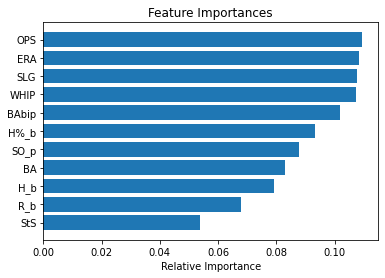

In [69]:
# plot feature importances from random forest
features = X.columns
importances = random_forest.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), features[indices])
plt.xlabel("Relative Importance");

## Results

In [55]:
results = pd.DataFrame({"prob": random_forest.predict_proba(X_test)[:, 1], "actual": y_test})

for c in [0.5, 0.6, 0.7, 0.8, 0.9]:
    results_with_conf = results[results["prob"] > c]
    conf_acc = str(results_with_conf["actual"].sum() / len(results_with_conf))
    print("accuracy for over {} conf: ".format(c) + conf_acc + " ({} instances)".format(len(results_with_conf)))

accuracy for over 0.5 conf: 0.6098356201603043 (7361 instances)
accuracy for over 0.6 conf: 0.6409101682863237 (4219 instances)
accuracy for over 0.7 conf: 0.6809563066776587 (1213 instances)
accuracy for over 0.8 conf: 0.7901234567901234 (81 instances)
accuracy for over 0.9 conf: 1.0 (2 instances)


In [56]:
# top 5 based on probability - all ended up recording hits
top_5 = results.sort_values("prob", ascending=False).head(5)
top_5

,prob,actual
11913,0.924915,1
12523,0.911259,1
17131,0.889857,1
12074,0.886426,1
16773,0.884989,1


In [57]:
# a look at the top 5
qualified.loc[top_5.index]

,game_date,game_pk,batter,hit,Name_b,_b,Age_b,...,H%_p,MLBID_x,bats,MLBID_y,throws,hand_matchup,lefty_lefty
11913,2021-07-16,633323,664058,1,David Fletcher,gl,27,...,0.204678,664058.0,R,623167.0,R,RR,0
12523,2021-07-20,633207,664058,1,David Fletcher,gl,27,...,0.185185,664058.0,R,621076.0,R,RR,0
17131,2021-08-16,632813,596115,1,Trevor Story,gl,28,...,0.299213,596115.0,R,677960.0,L,RL,0
12074,2021-07-17,633286,664058,1,David Fletcher,gl,27,...,0.194444,664058.0,R,579328.0,L,RL,0
16773,2021-08-14,632894,516782,1,Starling Marte,gl,32,...,0.211268,516782.0,R,621076.0,R,RR,0


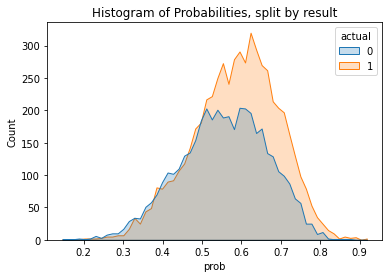

In [73]:
sns.histplot(results, x="prob", hue="actual", element="poly");
plt.title("Histogram of Probabilities, split by result");

## Conclusion

As hard as it is for me to admit, correctly predicting outcomes in sports is very challenging. In baseball (a so-called game of inches), a tiny lapse in concentration or delay in decision-making can be the difference between a hit and an out. Because there is so much unexplained variance, a model can only do so much.

That said, this project has helped me shift the probabilities in my favor, even if only slightly. In the histogram above, we see that a gap begins to widen between instances of hit & no-hit for probabilities above 0.5. Remember the problem at hand too: we only need to choose one player per day, meaning we only have to worry about the right side of the graph. For probabilities above 0.8, our accuracy is 79%, an edge over random selection or just choosing the average player we looked at in the beginning.

Putting my model to the test, I was able to achieve a streak of 29!

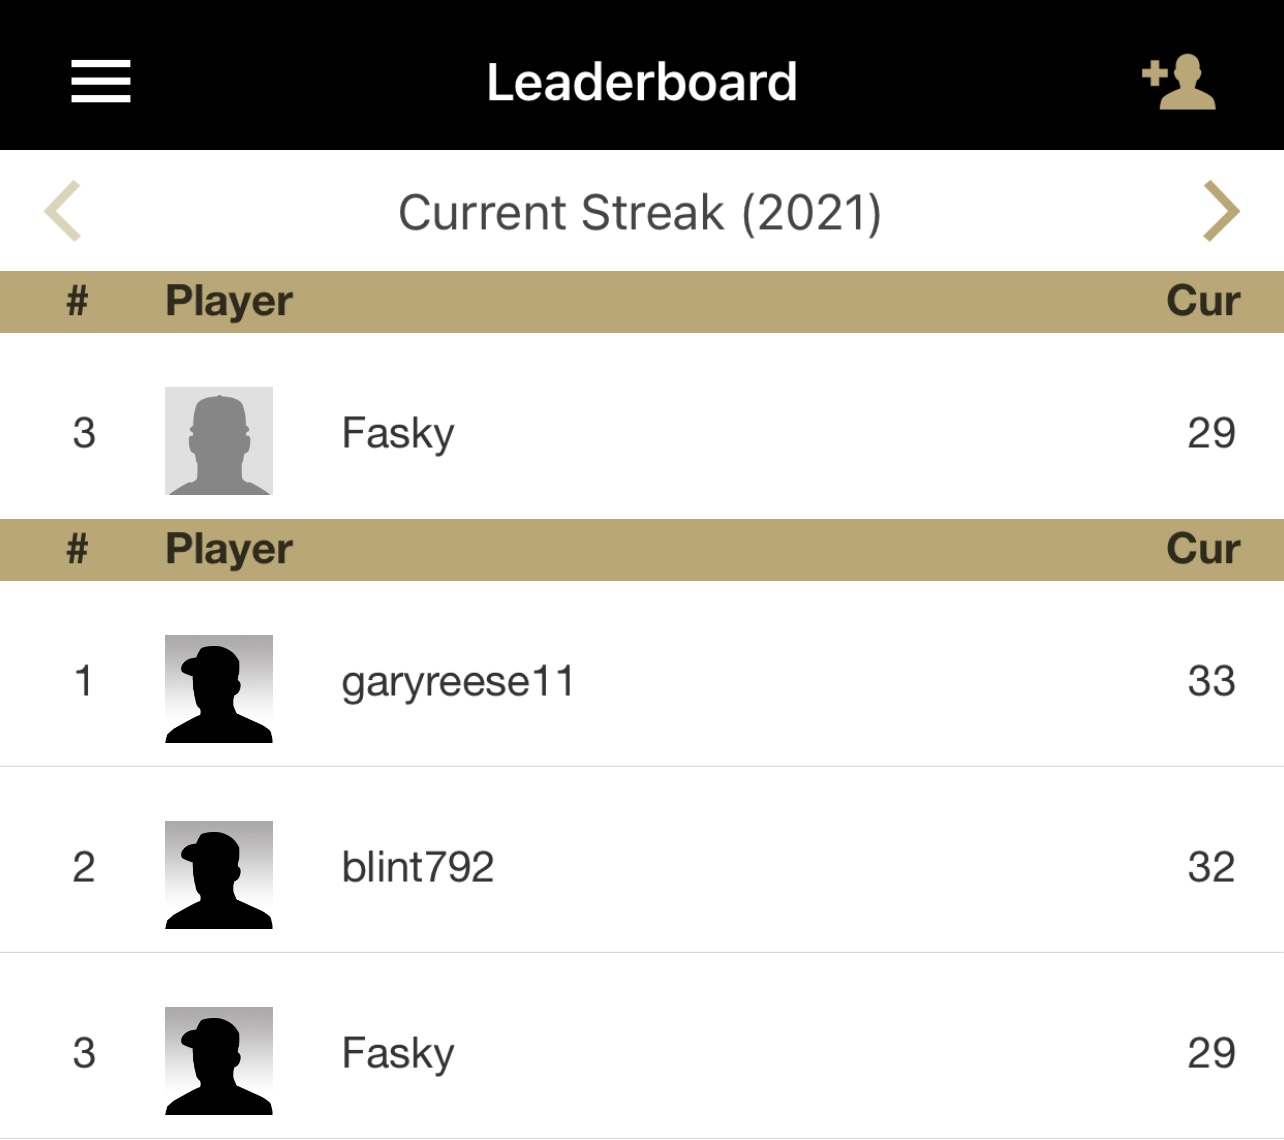

In [78]:
Image(filename="bts_leaderboard.jpg", width=300, height=300)